## X-ray chest - pneumonia detection


In [8]:
# Common
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import gc
from glob import glob
import shutil
import random
from glob import glob
%matplotlib inline

# Graphic
import matplotlib.pyplot as plt
import seaborn as sns


##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
#Keras (https://keras.io/api/metrics/)
#from tensorflow.keras import layers
#scikit-learn (https://scikit-learn.org/stable/)
# sklearn
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,recall_score, precision_score, confusion_matrix, f1_score,classification_report,precision_recall_curve
#from f1_score import calc_f1


# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import model_from_json
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Conv2D, MaxPooling2D



Using TensorFlow backend.


# 1. Pre-processing

## 1.1. Do some early processing of your metadata for easier model training:

### 1.1.1. add new column with the path to image

In [9]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
34023,00008908_003.png,Infiltration,3,8908,69,F,PA,2048,2500,0.168000,0.168000,NaN,/data/images_004/images/00008908_003.png
61779,00015266_002.png,Effusion,2,15266,76,F,PA,2992,2991,0.143000,0.143000,NaN,/data/images_007/images/00015266_002.png
110404,00030077_010.png,Pneumothorax,10,30077,66,F,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030077_010.png


### 1.1.2. Add coumn for each decease from the 'Finding Labels' column

In [10]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases
## rather than working directly with the 'Finding Labels' column
##
finding_labels = set('|'.join(all_xray_df['Finding Labels']).split('|'))

for label in finding_labels:
  all_xray_df[label] = all_xray_df['Finding Labels'].apply(lambda x: 1 if label in x else 0)
#drop Findings label once decease has been split in different columns
all_xray_df = all_xray_df.drop(['Finding Labels'], axis=1)
#drop usless columm 
all_xray_df = all_xray_df.drop(['Unnamed: 11'],axis=1)

In [11]:
column_headers = all_xray_df.columns
column_headers

Index(['Image Index', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]',
       'OriginalImagePixelSpacing[x', 'y]', 'path', 'Emphysema', 'Hernia',
       'Effusion', 'Pleural_Thickening', 'Pneumonia', 'Infiltration',
       'Pneumothorax', 'Atelectasis', 'Edema', 'Consolidation', 'No Finding',
       'Nodule', 'Cardiomegaly', 'Fibrosis', 'Mass'],
      dtype='object')

### 1.1.3. Add a column with the number of disease per record

In [12]:
disease_columns = finding_labels.copy()
disease_columns.remove('No Finding')
all_xray_df['disease_number']=all_xray_df[disease_columns].sum(axis=1)

### Eliminate wrong input detected within the EDA phase but also patient aged more than 60 years with high risk of complication 

#### Age < 120

In [13]:
all_xray_df = all_xray_df[all_xray_df['Patient Age']<=60]
all_xray_df = all_xray_df[all_xray_df['Patient Age']>=20]

print(len(all_xray_df))

80633


##### Eliiminate Images with outlier formats 

width:  [array([2500., 2500., 2992., 2992., 2500.])]
height:  [array([2048., 2048., 2991., 2991., 2048.])]
opx: [array([0.143, 0.143, 0.168, 0.168, 0.143])]
opy: [array([0.143, 0.143, 0.168, 0.168, 0.143])]


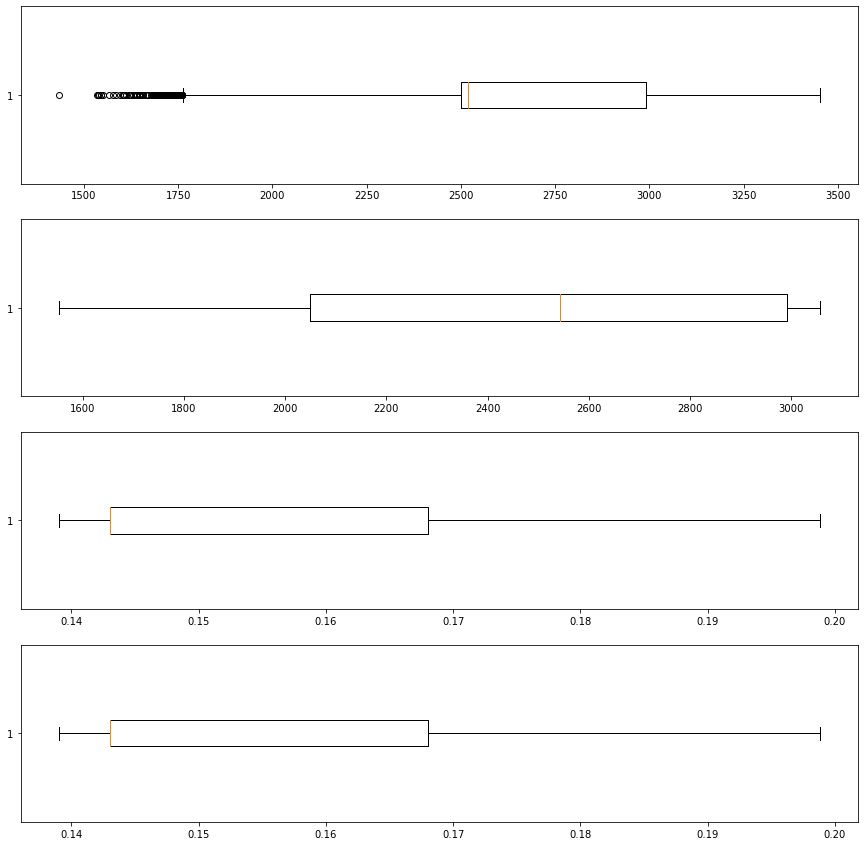

In [14]:
fig,ax = plt.subplots(4,1,figsize=(15,15))
b_dict_w= ax[0].boxplot([all_xray_df['OriginalImage[Width']],vert=False)
b_dict_h= ax[1].boxplot([all_xray_df['Height]']],vert=False)
b_dict_opx= ax[2].boxplot([all_xray_df['OriginalImagePixelSpacing[x']],vert=False)
b_dict_opy= ax[3].boxplot([all_xray_df['y]']],vert=False)

boxes_w = [box.get_xdata() for box in b_dict_w['boxes']]
boxes_h = [box.get_xdata() for box in b_dict_h['boxes']]
boxes_opx = [box.get_xdata() for box in b_dict_opx['boxes']]
boxes_opy = [box.get_xdata() for box in b_dict_opy['boxes']]

print(f"width:  {boxes_w}")
print(f"height:  {boxes_h}")
print(f"opx: {boxes_opx}")
print(f"opy: {boxes_opy}")
fig.show()

In [15]:
whiskers_w = [whisker.get_xdata() for whisker in b_dict_w['whiskers']]
w_low=whiskers_w[0][1]
w_high=whiskers_w[1][1]
#print(f'{w_low} - {w_high}')
whiskers_h = [whisker.get_xdata() for whisker in b_dict_h['whiskers']]
h_low=whiskers_h[0][1]
h_high=whiskers_h[1][1]
print(f'{h_low} - {h_high}')
all_xray_df = all_xray_df[all_xray_df['OriginalImage[Width']>w_low]
all_xray_df = all_xray_df[all_xray_df['OriginalImage[Width']<w_high]
all_xray_df = all_xray_df[all_xray_df['Height]']>h_low]
all_xray_df = all_xray_df[all_xray_df['Height]']<h_high]

1552.0 - 3056.0


# 2. Case data splitting 

In [16]:
data_size = len(all_xray_df)

In [17]:
data_size

78704

## 2.1. Get all normal cases

In [18]:
nodisease_df = all_xray_df[all_xray_df['No Finding']==1]
nodisease_data_size = len( nodisease_df)

## 2.2. Get diseased cases

In [19]:
disease_df = all_xray_df[all_xray_df['No Finding']==0]
disease_data_size = len(disease_df)

## 2.4. Get other disease cases without pneumonia

In [20]:
disease_wo_pneumonia_df = disease_df[disease_df.Pneumonia==0]
disease_wo_pneumonia_data_size = len(disease_wo_pneumonia_df)

## 2.5. Get pneumonia cases

In [21]:
disease_pneumonia_df= disease_df[disease_df.Pneumonia==1]
disease_pneumonia_data_size = len(disease_pneumonia_df)

### 2.5.1. Get pure pneumonial cases

In [22]:
pneumonia_pure_df= disease_pneumonia_df[disease_pneumonia_df.disease_number<2]
pneumonia_pure_data_size = len(pneumonia_pure_df)

### 2.5.2. Get pneumonia with other disease case

In [23]:
pneumonia_other_df = disease_pneumonia_df[disease_pneumonia_df.disease_number>1]
pneumonia_other_data_size = len(pneumonia_other_df)


In [24]:
print(f'Healthy cases                 : {nodisease_data_size}')
print(f'Disease cases                 : {disease_data_size}')
print(f'  Not pneumonia cases         :   {disease_wo_pneumonia_data_size}') 
print(f'  Pneumonia cases             :   {disease_pneumonia_data_size}')
print(f'    -Pure cases               :     {pneumonia_pure_data_size}')
print(f'    -With other diseases cases:     {pneumonia_other_data_size}')
print(f'Total cases                   : {data_size}' )      
      

Healthy cases                 : 43328
Disease cases                 : 35376
  Not pneumonia cases         :   34389
  Pneumonia cases             :   987
    -Pure cases               :     224
    -With other diseases cases:     763
Total cases                   : 78704


# 3. Create your training and testing data:

## 3.1. Strategy

We'll have 2 categories:

 - Negative (Healthy or other diseases) = 0
 - Pneumonia (with/without other diseases) = 1

Because of the relatively few case of pneumonia case (1430) , we will augment using **geometrical** transformation using Keras data generator to some extends to have at least a ratio of 1/10 of the healthy cases. Since we don't have acces to radiologist to label image and we were not successful to extract distinct patterns when analysing image pixels , we won't use custom augmmentation by blurring or somoothing images.  

On the other side we will tray to reduce by balancing not pneumonial case cross gender and age.

Once, this augmentation done , we will initializing a convolutional neural network (CNN) with class weights calculate with the following formulas:

weight_class_x = (1 / COUNT_CLASS_X) * (TOTAL_SAMPLES) / n

n= number of class
x = [1....n]

Note : due to technical no resolved issues in our environment, unfortunately we can't run all the generation in the same session at onces without the kernel beeing interupted will be interrupted  , we 'll generate each category separrately within files to prepare the training and testing phase


## 3.2. Set labels

In [25]:
#nodecease_df=nodecease_df.drop(columns=['category'])
#decease_wo_pneumonia_df=decease_wo_pneumonia_df.drop(columns=['category'])
#pneumonia_pure_df=pneumonia_pure_df.drop(columns=['category'])
#pneumonia_other_df=pneumonia_other_df.drop(columns=['category'])
#nodecease_df['category']
categories = ['NO_PNEUMONIA','PNEUMONIA'] 


In [26]:

#nodisease_df=nodecease_df.copy()
nodisease_df.loc[:, 'category'] = categories[0]
#disease_wo_pneumonia_df= disease_wo_pneumonia_df.copy()
disease_wo_pneumonia_df.loc[:, 'category'] = categories[0]

pneumonia_pure_df = pneumonia_pure_df.copy()
pneumonia_pure_df.loc[:,'category']=categories[1]
pneumonia_other_df = pneumonia_other_df.copy()
pneumonia_other_df.loc[:,'category']=categories[1]
#pneumonia_all_df= pd.concat([pneumonia_pure_df,pneumonia_other_df],ignore_index=True)
#shuffle
#pneumonia_all_df = pneumonia_all_df.sample(frac=1).reset_index(drop=True)

#not rally nice code , but we have to merge the pneumonia case for technical issue when trainig 
#w_p_o = len(pneumonia_other_df)
#w_p_p = len(pneumonia_pure_df)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## 3.2. Data preparation

## 3.2.0. Helper's Functions and infrastructure

In [27]:
'''
Function to append file paths to a specific category and type of data in the dictionary

'''
def append_to_paths_dictonary(paths_dic, data_type,category, path):
    if data_type in paths_dic:
        if category in paths_dic[data_type]:
            print(f'append - {category}.{data_type}')
            paths_dic[data_type][category].append(path)
        else:
            print(f'new - {data_type}.{category}')
            paths_dic[data_type][category] = [path]
    else:
        paths_dic[data_type] = {category: [path]}
        
'''
Function to access the filepath in the paths_dict with the category and type of data as parameter
'''
def get_from_paths_dictonary(paths_dic,data_type,category):
    if data_type in paths_dic and category in paths_dic[data_type]:
        return paths_dic[data_type][category]
    else:
        return None
    
def get_from_paths_type(paths_dic,data_type): 
    if data_type in paths_dic:
        for key, value in paths_dic[data_type].items():
            return(os.path.dirname(value[0]))
    else:
        return None 
    
'''
Function to get all file paths from the dictionary
'''    
def get_all_paths_from_paths_dictionary(paths_dic):
    all_paths = []
    for type,categories in paths_dic.items():
        for file_type, paths in categories.items():
            all_paths.extend(paths)
    return all_paths    

def remove_directory(path):
    """
    Removes a directory and its contents.

    Parameters:
        path (str): Path to the directory to be removed.
    """
    try:
        shutil.rmtree(path)
        print(f"Directory '{path}' and its contents removed successfully.")
    except Exception as e:
        print(f"Error removing directory '{path}': {e}")

In [28]:
## Initialization procedure
import os

generated_root_dir = '/workspace/home/generated'

# Create the main directory
os.makedirs(generated_root_dir, exist_ok=True)

# Initialize an empty directory for generated paths for each category and type of data
generated_file_paths_dic = {}

#generate filepaths directory names
for category in categories:
    #test_path = f'{generated_root_dir}/test/{category}'
    #append_to_paths_dictonary(generated_file_paths_dic,'test',category,test_path)
    train_path = f'{generated_root_dir}/train/{category}'
    append_to_paths_dictonary(generated_file_paths_dic,'train',category,train_path)
    val_path = f'{generated_root_dir}/val/{category}'
    append_to_paths_dictonary(generated_file_paths_dic,'val',category,val_path)

    
    
paths_to_create = get_all_paths_from_paths_dictionary(generated_file_paths_dic)

# clean
regenerate=False
if regenerate:
    for path  in paths_to_create:
        remove_directory(path)
        print(f"Directory '{path}' and its contents removed successfully.")


    #Create subdirectories
    for path  in paths_to_create:
        os.makedirs(path, exist_ok=True)
        print(f"Directory '{path}' and its contents created successfully.")


new - train.PNEUMONIA
new - val.PNEUMONIA


### 3.2.0.1 Image generator function

### 3.2.0.2 Prepare training and validation data

In [29]:
import sklearn.model_selection as skl

def prepare_data(df,criteria , test_size = 0.2):
    train_df, valid_df = skl.train_test_split(df, 
                                   test_size = test_size, 
                                   stratify = df[criteria] if criteria is not None else None)
    
    if criteria is not None:
        criteria_idxs = df[df[criteria]==1].index.tolist()
        not_criteria_idxs = df[df[criteria]==0].index.tolist()
        print('train percentage',len(train_df)/len(df))
        print('validation percentage',len(valid_df)/len(df))
        criteria_len = len(criteria_idxs)
        not_criteria_len = len(not_criteria_idxs)
    
        percent_critera = criteria_len/len(df)
        percent_not_critera = not_criteria_len/len(df)

        print(f'percent criteria {criteria}: {percent_critera}')
        print(f'percent non criteria {criteria}: {percent_not_critera}')
    train_df_size=len(train_df)
    valid_df_size=len(valid_df)
    print(f'train data size: {train_df_size}')
    print(f'valid data size: {valid_df_size}')
    return train_df,train_df_size,valid_df,valid_df_size

In [30]:
#%more Data_Entry_2017.csv

In [31]:
def generate_transform_images(data_generator,df,src_dir,tgt_dir,factor,path,category_fieldname, data_type = 'train'):
    print(f'start images transfomation and generation...')
    n=0
    for index, row in df.iterrows():
        image_path = os.path.join(src_dir, row[path])
        category = row[category_fieldname]

        img = load_img(image_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        i = 0
        # Generate a unique filename using current timestamp and a counter
        timestamp = int(time.time())
        save_to_dir = os.path.join(tgt_dir, data_type, category)
        

        for batch in data_generator.flow(x, batch_size=1, save_to_dir=save_to_dir, save_format='jpeg'):
            i += 1
            if i >= factor: 
                break
        n += i 
    print(f'end images transfomation and generation {n}.')


## 3.2.3.Balance and generate of other decease and healthy cases

### 3.2.3.1 Function for data balancing

In [32]:
# Example usage:
# Replace 'your_dataset.csv' with your dataset file path and specify the column names and total_rows_to_select.
# balanced_data = balance_dataset(df, ['age', 'gender'], 100)
def select_balanced_dataset(df, column_names, total_rows_to_select):
    # Calculate the total number of rows you want to select
    num_groups = df.groupby(column_names).size().shape[0]
    min_records_per_group = round(total_rows_to_select / num_groups)

    # Initialize an empty DataFrame to store the sampled rows
    balanced_df = pd.DataFrame(columns=df.columns)
    selected_indexes = []
    groupes_count = {}
    # Randomly sample from each group
    for _, group in df.groupby(column_names):
        count = group.shape[0]
        if count >= min_records_per_group:
            # If the group has enough records, sample the required number
            sample = group.sample(min_records_per_group, random_state=42)
        else:
            # If the group has fewer records than required, sample all of them
            sample = group    
        # Add the sampled rows to the balanced DataFrame
        balanced_df = pd.concat([balanced_df, sample])

        #store the index
        selected_indexes.extend(sample.index)
        
    # If you want a completely random subset, shuffle the resulting DataFrame
    balanced_df = balanced_df.sample(frac=1, random_state=42)

    return balanced_df , selected_indexes

### 3.2.3.2. Balanced selection of other than pneumonia desease cases

Pickup  ~ 2 * generated pneumonia ( ~10000 training case and 3000 test case) ->  25000 cases

In [33]:
selection_number = 8000//4
balanced_disease_wo_pneumonia_df,selected_index = select_balanced_dataset(disease_wo_pneumonia_df, column_names = ['Patient Age','Patient Gender','View Position' ], total_rows_to_select = selection_number)


In [34]:
print(f'balanced_disease_wo_pneumonia_df size: {len(balanced_disease_wo_pneumonia_df)}')

balanced_disease_wo_pneumonia_df size: 1968


Check if balanced cross Gender,age and view postion

(array([984.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 984.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

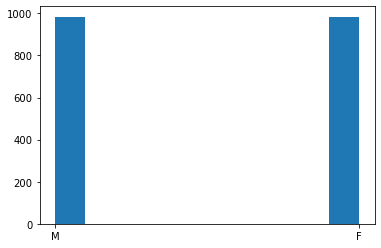

In [35]:
plt.hist(balanced_disease_wo_pneumonia_df['Patient Gender'])

(array([192., 192., 192., 192., 192., 192., 192., 192., 192., 240.]),
 array([20.0, 24.0, 28.0, 32.0, 36.0, 40.0, 44.0, 48.0, 52.0, 56.0, 60.0],
       dtype=object),
 <a list of 10 Patch objects>)

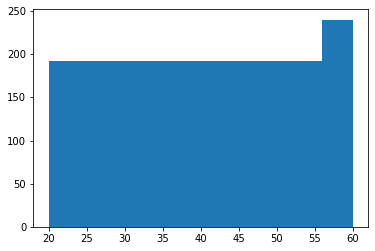

In [36]:
plt.hist(balanced_disease_wo_pneumonia_df['Patient Age'])

(array([192., 192., 192., 192., 192., 192., 192., 192., 192., 240.]),
 array([20.0, 24.0, 28.0, 32.0, 36.0, 40.0, 44.0, 48.0, 52.0, 56.0, 60.0],
       dtype=object),
 <a list of 10 Patch objects>)

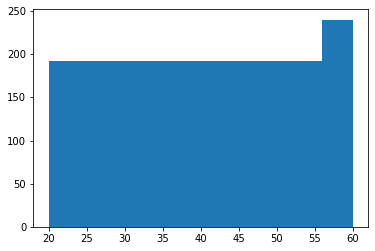

In [37]:
plt.hist(balanced_disease_wo_pneumonia_df['Patient Age'])

**Note:** there to few sample for age < 20 and >=80 to have a perfect equal rebalancing

(array([984.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 984.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

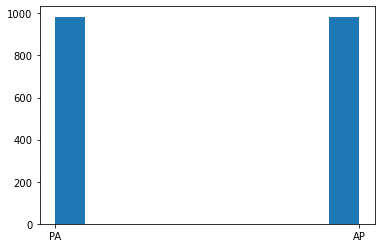

In [38]:
plt.hist(balanced_disease_wo_pneumonia_df['View Position'])

### 3.2.3.3. Balanced selection of healthy cases

In [39]:
selection_number = 8000//4
balanced_nodisease_df,selected_index = select_balanced_dataset(nodisease_df, column_names = ['Patient Age','Patient Gender','View Position' ], total_rows_to_select = selection_number)

In [40]:
print(f'balanced_nodisease_df: {len(balanced_nodisease_df)}')


balanced_nodisease_df: 1968


### 3.2.3.5. Training and validation data

In [41]:
train_pneumonia_pure,train_pneumonia_pure_size,valid_pneumonia_pure,valid_pneumonia_pure_size =prepare_data(pneumonia_pure_df,None , test_size = 0.2)
train_pneumonia_other,train_pneumonia_other_size,valid_pneumonia_other,valid_pneumonia_other_size =prepare_data(pneumonia_other_df,None , test_size = 0.2)
train_nodisease,train_nodisease_size,valid_nodisease,valid_nodisease_size =prepare_data(balanced_nodisease_df,None , test_size = 0.2)
train_disease_wo_pneumonia,train_disease_wo_pneumonia_size,valid_disease_wo_pneumonia,valid_disease_wo_pneumonia_size =prepare_data(balanced_disease_wo_pneumonia_df,None , test_size = 0.2)

train data size: 179
valid data size: 45
train data size: 610
valid data size: 153
train data size: 1574
valid data size: 394
train data size: 1574
valid data size: 394


In [42]:
val_no_pneumonia = pd.concat([valid_nodisease,valid_disease_wo_pneumonia],ignore_index=True)
adjusted_val_no_pneumonia,selected_index = select_balanced_dataset(val_no_pneumonia, column_names = ['Patient Age','Patient Gender','View Position' ], total_rows_to_select =  (valid_pneumonia_other_size+valid_pneumonia_pure_size))


### 3.2.3.4. Initialize parameter for images generation 

In [43]:
# Define a custom normalization function
def z_score_normalization(image):
    # Apply your custom normalization method here
    # For example, subtract the mean and divide by the standard deviation
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image

In [44]:
rescale= 1./255
h_flip=True
h_shift_range=0.05
w_shift_range=0.05
rotation_range=7
zoom_range=0.1
#brightness_range=[0.4,1.5]
classes = categories
class_mode ='categorical'
x_col = 'path'
y_col = 'category'

tgt_size = (224,224)
batch_size = 128
# generator with modification and rescale
img_augmented_gen = ImageDataGenerator(preprocessing_function=z_score_normalization,
#                             rescale=rescale,
                             horizontal_flip = h_flip,
                             vertical_flip = False,
                             height_shift_range = h_shift_range,
                             width_shift_range = w_shift_range,
                             zoom_range = zoom_range,
                             rotation_range = rotation_range)
 #                            brightness_range= brightness_range,      
 #                            fill_mode='nearest',
 #                            zoom_range = zoom_range,
 #                            fill_mode='nearest')
# generator with rescale and withoud modification
img_original_gen = ImageDataGenerator(preprocessing_function=z_score_normalization)

### 3.2.3.5 Augmentation  pneumonia cases generators

In [45]:
#factor = 4 
factor = 3 
# Generate training pure pneumonia images
#regenerate = True
#regenerate = False

if regenerate:
    generate_transform_images(img_augmented_gen,pd.concat([train_pneumonia_pure,train_pneumonia_other],ignore_index=True), '/', generated_root_dir,factor , 'path','category')
    # Generate validation pure pneumonia images
    generate_transform_images(img_original_gen,pd.concat([valid_pneumonia_pure,valid_pneumonia_other],ignore_index=True),'/', generated_root_dir,1 , 'path','category',data_type = 'val')
print(f'[gc]count {gc.get_count()}')
gc.collect()                             

[gc]count (254, 3, 9)


82

### generated_root_dir

In [46]:
%cd /workspace/home/generated/train/PNEUMONIA
%ls -1p | grep -v / | wc -l

/workspace/home/generated/train/PNEUMONIA
2078


In [47]:
%cd /workspace/home/generated/val/PNEUMONIA
%ls -1p | grep -v / | wc -l

/workspace/home/generated/val/PNEUMONIA
195


### 3.2.3.7 Augmentation  no disease cases generators

In [48]:
factor = 1

if regenerate:
    # Generate training healthy images
    # use img_val_gen , becuase we don't want generation 
    generate_transform_images(img_original_gen,pd.concat([train_nodisease,train_disease_wo_pneumonia],ignore_index=True),'/', generated_root_dir,factor , 'path','category')
    # Generate validation healthy without pneumonia images
    generate_transform_images(img_original_gen,adjusted_val_no_pneumonia,'/', generated_root_dir,factor , 'path','category',data_type = 'val')
print(f'[gc]count {gc.get_count()}')
gc.collect()  

[gc]count (408, 0, 0)


60

In [49]:
%cd /workspace/home/generated/train/NO_PNEUMONIA
%ls -1p | grep -v / | wc -l

/workspace/home/generated/train/NO_PNEUMONIA
2698


In [50]:
%cd /workspace/home/generated/val/NO_PNEUMONIA
%ls -1p | grep -v / | wc -l

/workspace/home/generated/val/NO_PNEUMONIA
161


In [51]:
# reinit
%cd  /workspace/home/

/workspace/home


###### 3.2.3.5 generator for training and validation based on previously created images

In [52]:
train_dir = get_from_paths_type(generated_file_paths_dic,'train')
print(f'Training directory: {train_dir}')
val_dir = get_from_paths_type(generated_file_paths_dic,'val')
print(f'Validation directory: {val_dir}')

Training directory: /workspace/home/generated/train
Validation directory: /workspace/home/generated/val


In [53]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_data = train_datagen.flow_from_directory(
             directory=train_dir,
             batch_size=batch_size,
             target_size = tgt_size,
             class_mode='categorical')

val_data = val_datagen.flow_from_directory(
             directory=val_dir,
             batch_size=batch_size,
             target_size = tgt_size,
             class_mode='categorical')

# Number of train and validation steps
train_steps=train_data.n//batch_size
val_steps=val_data.n//batch_size

Found 4776 images belonging to 2 classes.
Found 356 images belonging to 2 classes.


In [54]:
#X_val_1, Y_val_1 = valid_gen_1.next()
#X_val_2, Y_val_2 = valid_gen_2.next()

# 4  Model-building & training

#### First suggestion: perform some image augmentation on your data

In [55]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
show_image = False
if show_image:
    t_x, t_y = next(train_gen)
    fig, m_axs = plt.subplots(4, 2, figsize = (20, 20))
    for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
        c_ax.imshow(c_x[:,:,0], cmap = 'bone')
        print(c_y)
        if c_y[1] == 1: 
            c_ax.set_title('Pneumonia')
        else:
            c_ax.set_title('No Pneumonia')
        c_ax.axis('off')

## 4.1 Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [56]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense,Dropout,GlobalAveragePooling2D,AveragePooling2D,MaxPooling2D,Conv2D,Activation,Add,PReLU

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
#from keras.models import Sequential
from tensorflow.python.keras.models import Sequential


In [57]:
def attention_block(inputs, filters):
    # First Convolution layer
    conv1 = Conv2D(filters, (3, 3), padding='same')(inputs)
    conv1 = Activation('relu')(conv1)

    # Second convolution layer
    conv2 = Conv2D(filters, (3, 3), padding='same')(conv1)
    conv2 = Activation('relu')(conv2)

    # Attention Mechanism
    attn = Add()([conv1, conv2])
    attn = Activation('relu')(attn)
    attn = Conv2D(1, (1, 1), padding='same')(attn)
    attn = Activation('softmax')(attn)

    # Multiply the input with the attention map
    output = tf.multiply(inputs, attn)
    return output


In [58]:
def create_output_layers(x,dropout):
    # Add dropout layer after Flatten layer
    x = Dropout(dropout)(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    #x = Dropout(dropout)(x)
    #x = Dense(512, activation='relu', name='fc2')(x)
    #x = Dropout(dropout)(x)

    #x = PReLU()(x)  # The slope is learned during training
    #x = Dropout(dropout)(x)  # Dropout rate can be adjusted
    #x = Dense(4096, activation='relu', name='fc2')(x)
    return x

In [59]:
# Model architechture
def create_simple(num_classes,node_number,dropout=0.24,input_shape= (224,224,3)):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2,activation='softmax'))
    return model

In [66]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2


def create_custom_VGG16(num_classes,node_number,dropout=0.5,input_shape= (224,224,3), num_trainable_layers=20,l2_reg = 1e-5):

    # Load pre-trained VGG16 model (exclude top layers)
    base_model = VGG16(weights='imagenet', include_top=False,input_shape = input_shape)


    # Apply attention block
    # inpired by https://www.nature.com/articles/s41598-022-27266-9
    #if attention:
    #    x = attention_block(base_model.output, 64)  # Adjust filters as needed
    #else:
    x=  base_model.output
    x = Dropout(dropout)(x)
    x = Flatten(name='flattenCustom')(x) 
    x = Dense(node_number, activation='relu', name='fc1', kernel_regularizer=l2(l2_reg))(x)
    # x = Dropout(dropout)(x)
    # x = Dense(node_number, activation='relu', name='fc1')(x)
    # x = Dropout(0.7)(x)
    # x = Dense((node_number/2), activation='relu', name='fc2')(x)
    # x = Dropout(0.2)(x)
    # x = Dense(64,activation= 'relu',name='fc2')(x)
    # Classification layer
    predictions = Dense(num_classes, activation='softmax',name='fc2')(x)  # Replace 2 with your number of classes

    # Create the model
    model = tf.keras.Model(inputs=base_model.inputs, outputs=predictions)
    
    
    frozen_model_layers = model.layers
    if num_trainable_layers> 0:
        frozen_model_layers = model.layers[:-num_trainable_layers]
    for layer in frozen_model_layers:
        layer.trainable = False    # Freeze the specified number of layers

    return model

In [67]:
from tensorflow.keras.applications import ResNet50V2

def create_custom_resnet50v2(num_classes,dropout=0.2,input_shape= (224,224,3), flattening = True,num_trainable_layers=4):
    #base_model = ResNet50V2(weights='imagenet', include_top=False, pooling='avg',input_shape=input_shape)
    base_model = None
    if flattening:
        base_model=ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        base_model=ResNet50V2(weights='imagenet', include_top=False,  pooling='avg',input_shape=input_shape)
   
    #base_model.trainable= False
        
    x = base_model.output

    # Add dropout for regularization (optional)
    x = Flatten(name='flattenCustom')(x)
    x = Dropout(0.7)(x)
    x = Dense(512,activation='relu', name='fc1')(x)    
    x = Dropout(0,5)(x)
    #predictions = Dense(2, activation='softmax', name = 'fc2',kernel_initializer = glorot_uniform(seed=None))(x)  # Use a single neuron with sigmoid activation for binary classification
    predictions = Dense(2, activation='softmax', name = 'fc2')(x)  # Use a single neuron with sigmoid activation for binary classification

    model = Model(inputs=base_model.input, outputs=predictions)

    frozen_model_layers = model.layers
    if num_trainable_layers> 0:
        frozen_model_layers = model.layers[:-num_trainable_layers]
    for layer in frozen_model_layers:
        layer.trainable = False    # Freeze the specified number of layers
    
    return model


In [68]:
model_name = 'VGG16'
#model_name = 'SIMPLE'
#model_name = 'RESNET50V2'

node_number = 512
version    = '1.0'
learning_rate  = 0.001
decay=0.00005
limit_rate     = 0.0001
decrease_rate  = 0.1
dropout = 0.5
l2_reg = 1e-4 #, 1e-4, 1e-3, and 1e-2
parameters = 'n{}_l_r_{}_l{}_dr_{}_l2_{}_d{}_b{}'.format(node_number,learning_rate,limit_rate,decrease_rate,l2_reg,dropout,batch_size,l2_reg = l2_reg)

In [69]:
channel_nbr = 3
net= create_custom_VGG16(len(categories),node_number,dropout=dropout, input_shape = (tgt_size[0],tgt_size[1],channel_nbr),num_trainable_layers=6)

#net = create_simple(len(categories),node_number,dropout=dropout,input_shape= (tgt_size[0],tgt_size[1],channel_nbr))

#net = create_custom_resnet50v2(len(categories),dropout=0.2,input_shape = (tgt_size[0],tgt_size[1],channel_nbr),flattening=True,num_trainable_layers=5)
# display the structure of the model
# Check the trainable status of the individual layers
for layer in net.layers:
    print(layer, layer.trainable)
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(f"Layer Name: {layer.name}, Activation: {layer.activation.__name__}")

net.summary()
print('{}_{}_{} generated'.format(model_name,version,parameters))

58892288/58889256 [==============================] - 0s 0us/step
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7a34c6238e10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7a34443eb2d0> False
Layer Name: block1_conv1, Activation: relu
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7a34c6351690> False
Layer Name: block1_conv2, Activation: relu
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7a34c623ea90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7a34c62e9f50> False
Layer Name: block2_conv1, Activation: relu
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7a34c6279d50> False
Layer Name: block2_conv2, Activation: relu
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7a34c627d050> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7a34c62806d0> False
Layer Name: block3_conv1, Activation: relu
<tensorflow.python.keras.layers.convol

In [ ]:
# Convert the model to JSON-compatible dictionary
model_json = net.to_json()
# Serialize the dictionary to JSON format

model_path = '/workspace/home/{}_{}_{}.json'.format(model_name,version,parameters)
with open(model_path, "w") as json_file:
    json_file.write(model_json)

## 4.2 Training 

In [ ]:
categories_size  = [2685, 2248]
min_category_size = min(categories_size)
categories_weights = [x/min_category_size for x in categories_size]
class_weights_dict = dict(enumerate(categories_weights))
print(f'class_weights_dict : {class_weights_dict}')

In [ ]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting


weight_path_loss="/workspace/home/{}_{}_{}_loss.best.hdf5".format(model_name,version,parameters)
weight_path_acc="/workspace/home/{}_{}_{}_acc.best.hdf5".format(model_name,version,parameters)

checkpoint_1 = ModelCheckpoint(weight_path_loss, 
                             monitor= 'val_loss', #monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', #mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC,
                             save_weights_only = True)
#checkpoint_2 = ModelCheckpoint(weight_path_acc, 
#                             monitor= 'val_acc', #monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                             verbose=1, 
#                             save_best_only=True, 
#                             mode= 'max', #mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC,
#                             save_weights_only = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=decrease_rate, patience=4, min_lr=limit_rate)


early = EarlyStopping(monitor= 'val_loss',  #monitor= SAME_AS_METRIC_CHOSEN_ABOVE,
                       mode= 'auto', #mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC,
                       patience=6)

callbacks = [checkpoint_1, reduce_lr,early]

In [ ]:
#optimizer = Adam(lr=0.0001, decay=0.00005)
optimizer = Adam(lr=learning_rate)
#optimizer = RMSprop(learning_rate=learning_rate)

#optimizer = Adam()
#optimizer = SGD(learning_rate=0.01, momentum=0.9)

loss = 'categorical_crossentropy'
metrics = ['accuracy']
net.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
#epochs = 20
epochs = 25

history = net.fit(train_data, 
                  steps_per_epoch = train_steps,
                  validation_data=val_data,
                  validation_steps=val_steps,
                  epochs = epochs, 
                  class_weight=class_weights_dict,
                  callbacks = callbacks)



In [ ]:

# Access additional metrics if present
# additional_metric = history.history['your_additional_metric']
#epochs = 15
# Example: Plotting training and validation loss over epochs
import matplotlib.pyplot as plt

def plot_loss_history(history):
    n = len(history.history["loss"])
    plt.figure (figsize = (12,10))
    plt.plot(np.arange(0, n),history.history["loss"], label='Training Loss')
    plt.plot(np.arange(0, n),  history.history["val_loss"], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    filename = '{}_{}_{}_loss.jpg'.format(model_name,version,parameters)
    # Save the figure as a JPEG
    plt.savefig(filename, format='jpg', dpi=300)  # Adjust dpi as needed
    plt.show()

In [ ]:
# Access additional metrics if present
# additional_metric = history.history['your_additional_metric']
#epochs = 15
# Example: Plotting training and validation loss over epochs
import matplotlib.pyplot as plt

def plot_acc_history(history):
    n = len(history.history["accuracy"])
    plt.figure (figsize = (12,10))
    plt.plot(np.arange(0, n),  history.history["accuracy"], label='Accuracy')
    plt.plot(np.arange(0, n),  history.history["val_accuracy"], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    filename = '{}_{}_{}_acc.jpg'.format(model_name,version,parameters)

    plt.legend()
    # Save the figure as a JPEG
    plt.savefig(filename, format='jpg', dpi=300)  # Adjust dpi as needed
    plt.show()

In [ ]:
#plot_loss_history(history)
#plot_acc_history(history)

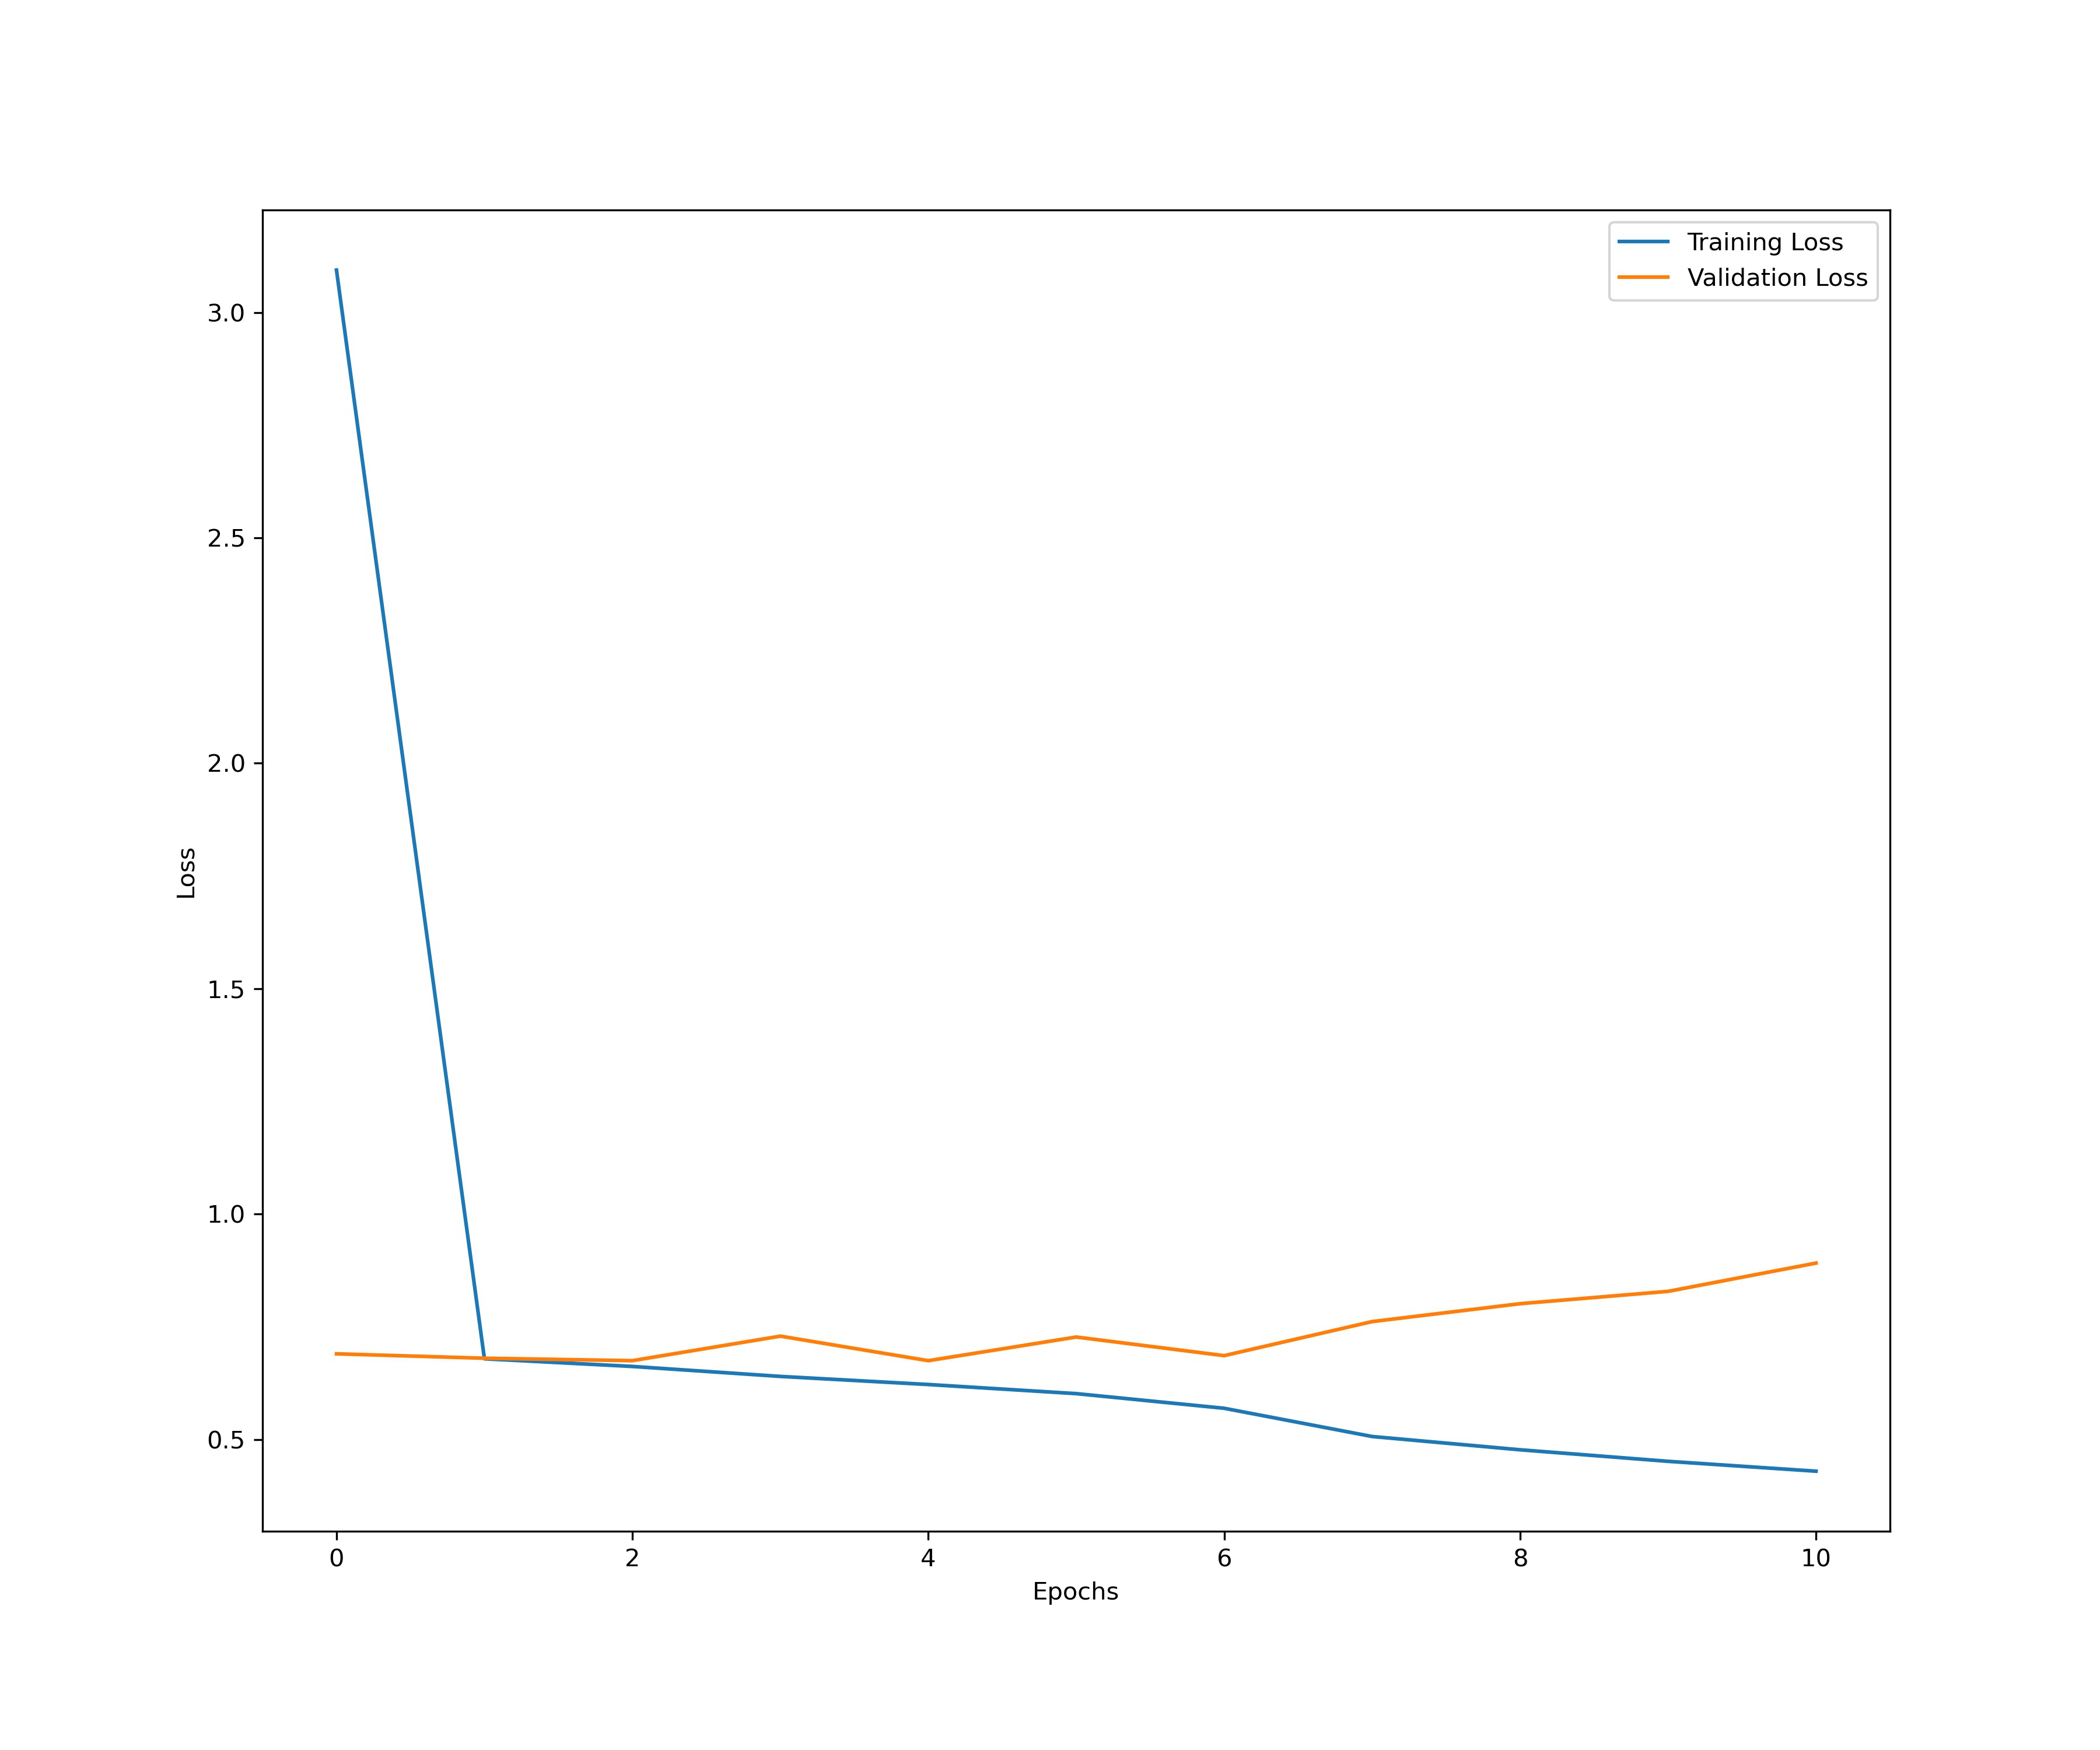

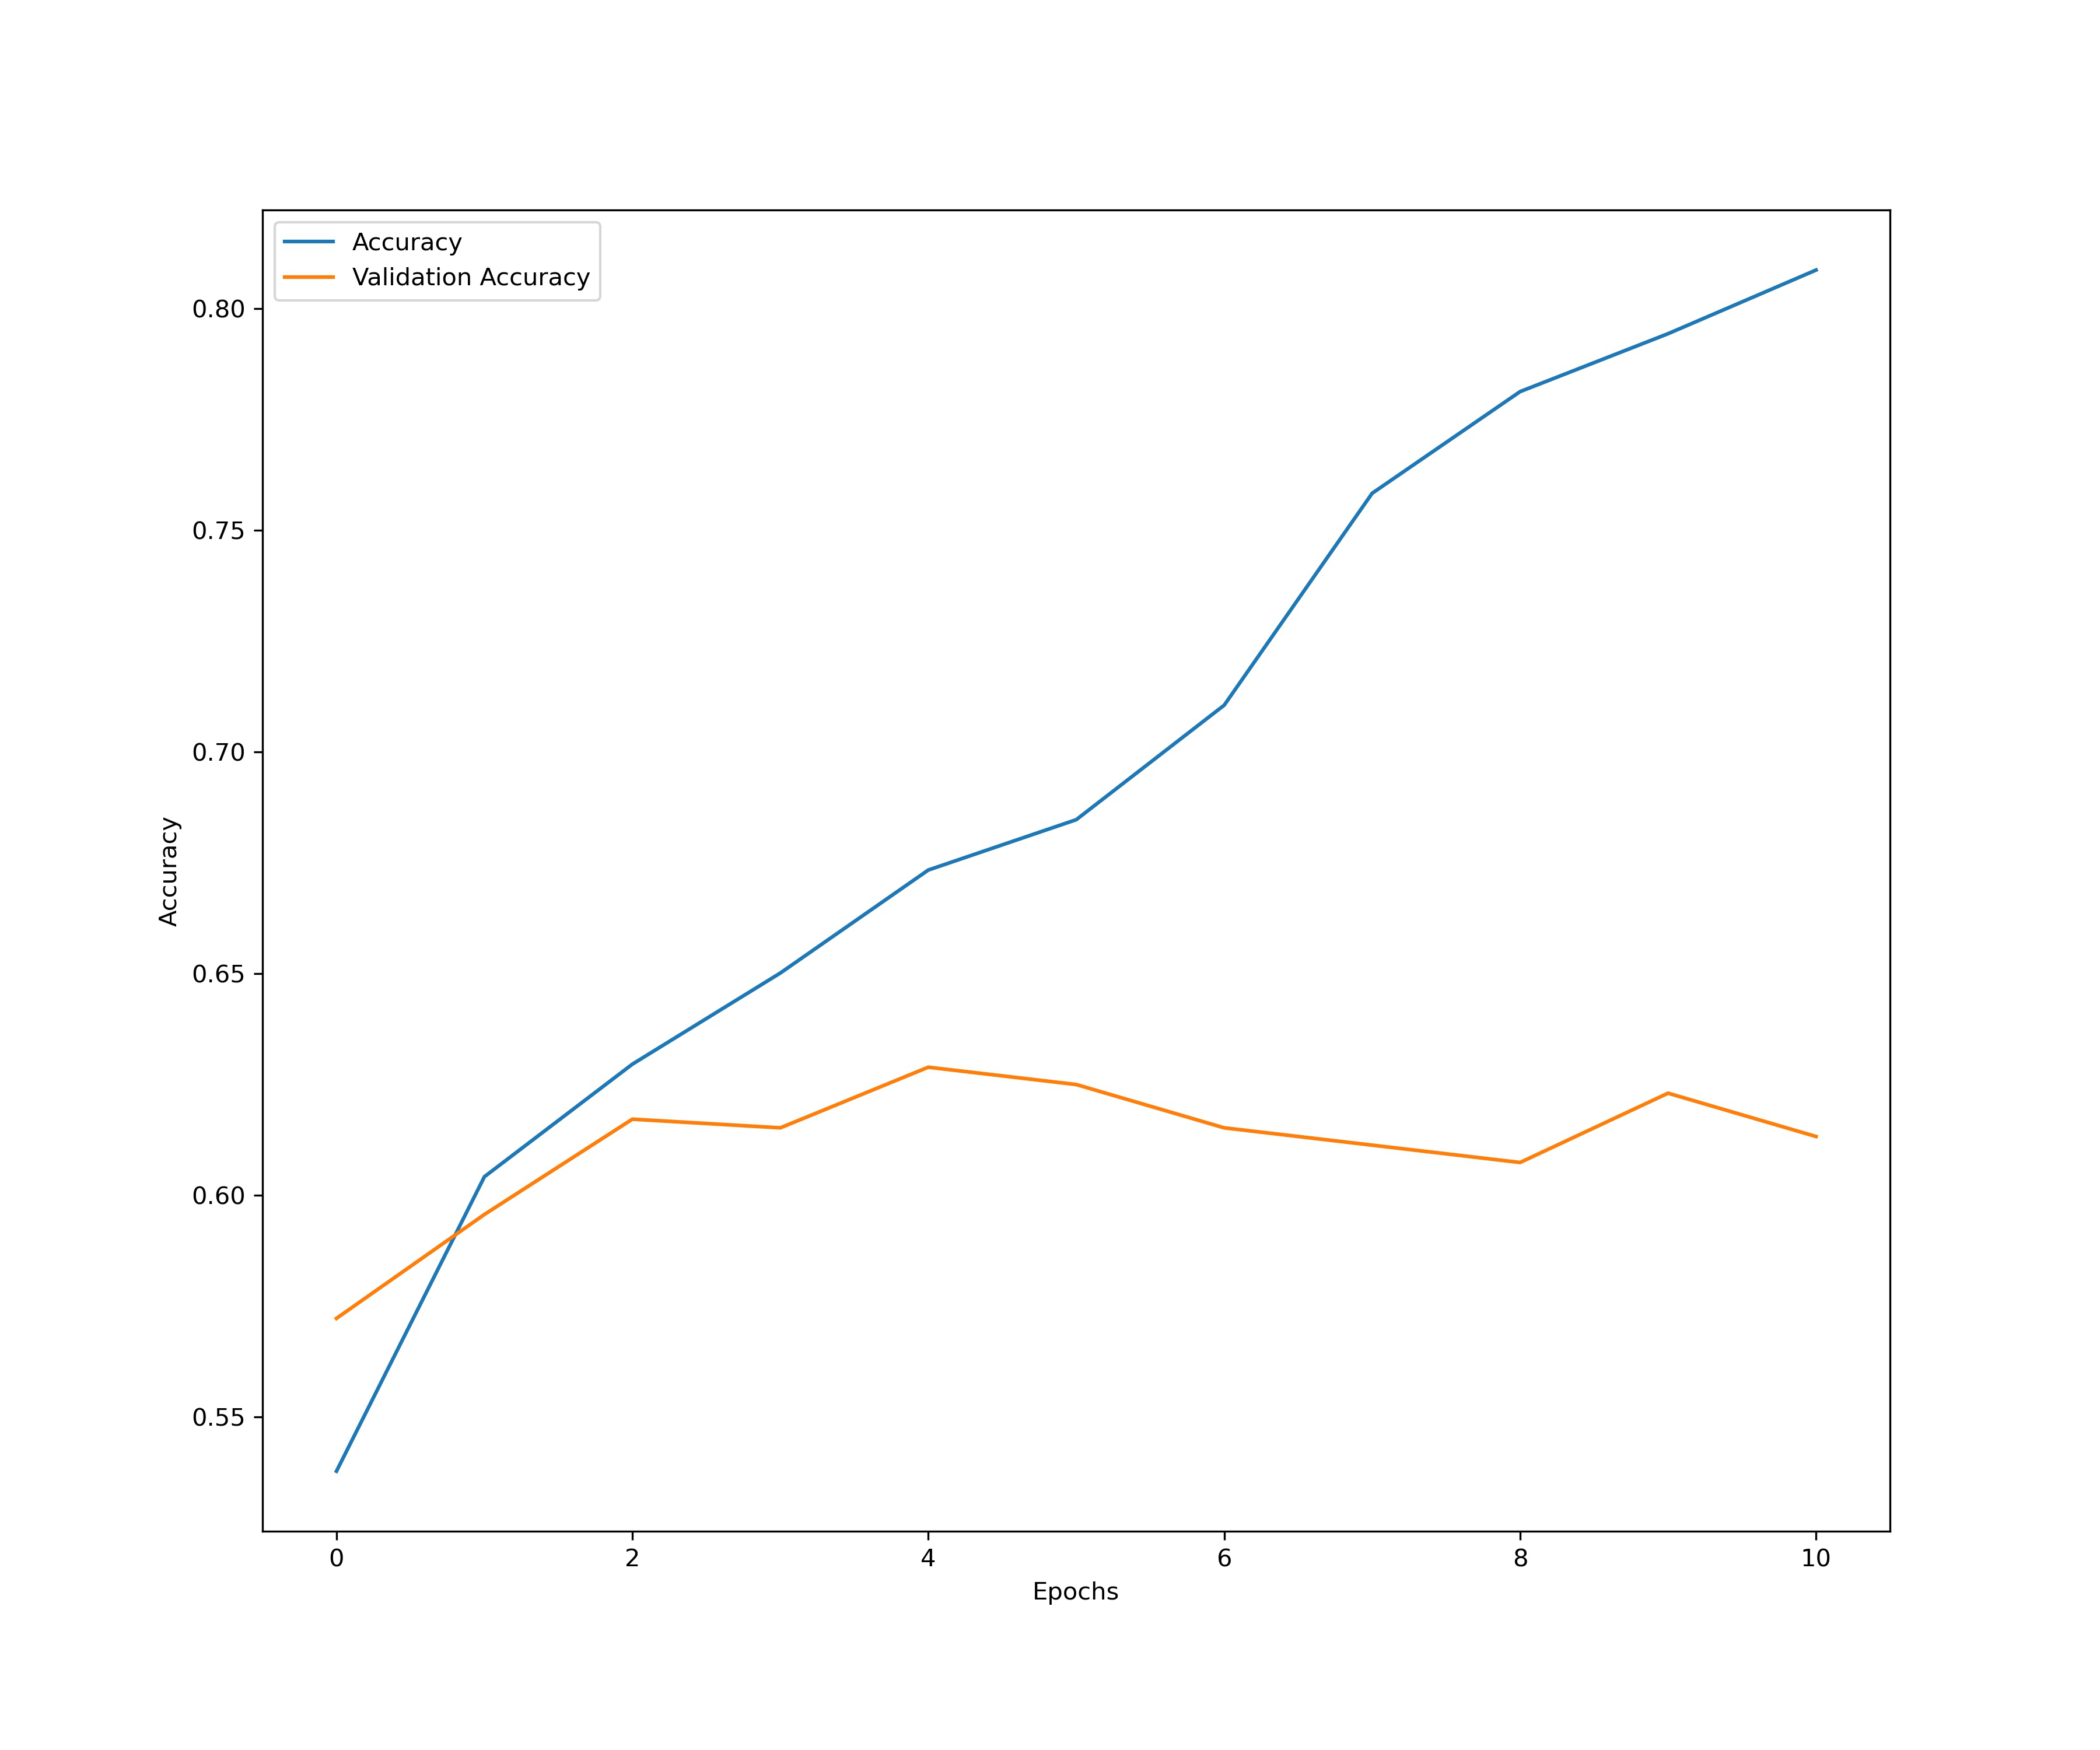

In [60]:
from PIL import Image
from IPython.display import display

# Load and display local image
img = Image.open('./img/VGG16_1.0_n512_l_r_0.001_l0.0001_dr_0.1_l2_0.0001_d0.5_b128_loss.jpg')
display(img)
img = Image.open('./img/VGG16_1.0_n512_l_r_0.001_l0.0001_dr_0.1_l2_0.0001_d0.5_b128_acc.jpg')
display(img)


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [61]:
Xs_test, Ys_test = next(val_data)


In [62]:
len(Xs_test)

128

In [70]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model_path = '/workspace/home/best/{}_{}_{}.json'.format(model_name,version,parameters)
#model_path = '/workspace/home/VGG_0_0.json'
#model_path = '/workspace/home/best/VGG16_1.0_n512_l_r_0.001_l0.0001_dr_0.1_l2_0.0001_d0.5_b128.json'

# Load the JSON file
with open(model_path, "r") as json_file:
    loaded_model_json = json_file.read()

# Create a new model from the JSON
loaded_model = model_from_json(loaded_model_json)
#test_batch_size = batch_size * test_batch_number
#weight_path = '/workspace/home/VGG_0_m_loss.best.hdf5'
weight_path_loss="/workspace/home/best/{}_{}_{}_loss.h5".format(model_name,version,parameters)
#weight_path_loss='/workspace/home/best/VGG16_1.0_n512_l_r_0.001_l0.0001_dr_0.1_l2_0.0001_d0.5_b128_loss.h5'


loaded_model.load_weights(weight_path_loss)
#y_pred = np.argmax(loaded_model.predict(valX, batch_size = 64, verbose = True),axis=-1)

In [71]:
for layer in loaded_model.layers:
    print(layer, layer.trainable)
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(f"Layer Name: {layer.name}, Activation: {layer.activation.__name__}")

loaded_model.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7a34c4cf6190> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7a34c4cf61d0> False
Layer Name: block1_conv1, Activation: relu
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7a34c4cf6390> False
Layer Name: block1_conv2, Activation: relu
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7a34c4cf6c10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7a34c4d00490> False
Layer Name: block2_conv1, Activation: relu
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7a34c4d00a50> False
Layer Name: block2_conv2, Activation: relu
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7a34c4cf6150> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7a34c4d03290> False
Layer Name: block3_conv1, Activation: relu
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7a34c4cf6f90> False
Layer Name: block3_

In [72]:
y_pred_stat = loaded_model.predict(Xs_test, batch_size = 64, verbose = True)
y_pred = np.argmax(y_pred_stat,axis=-1)

128/128 [==============================] - 86s 674ms/sample


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

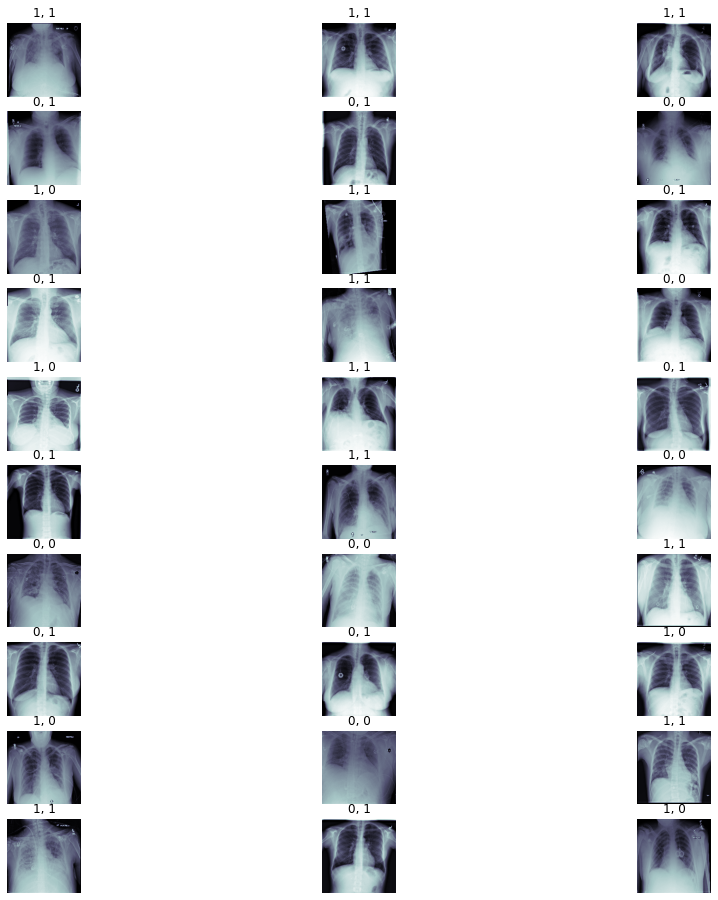

In [73]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 3, figsize = (16, 16))
i = 0
threshold = 0.5
for (c_x, c_y, c_ax) in zip(Xs_test[0:100], Ys_test[0:30], m_axs.flatten()):
     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
     if c_y[1] == 1: 
         if y_pred_stat[i][1] > threshold:
             c_ax.set_title('1, 1')
         else:
             c_ax.set_title('1, 0')
     else:
         if y_pred_stat[i][0] > threshold: 
             c_ax.set_title('0, 1')
         else:
             c_ax.set_title('0, 0')
     c_ax.axis('off')
     i=i+1

In [74]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

# Assuming your labels and predictions are NumPy arrays
y_true = Ys_test[:,1]

In [75]:
def plot_AUC_curve(y_true,y_pred,filename):
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    #filename="/workspace/home/img/{}_{}_{}_ROC.jpg".format(model_name,version,parameters)
    #filename="/workspace/home/VGG_0_m_loss_ROC_1.jpg"
    #plt.savefig(filename, format='jpg', dpi=300)  # Adjust dpi as needed
    plt.savefig(filename, format='jpg', dpi=300)  # Adjust dpi as needed
    plt.show()
    plt.close()

In [76]:
def plot_CM(y_true,y_pred,filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d')  # Annotate with values, format as integers
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig(filename, format='jpg')  # Adjust dpi as needed
    plt.show()
    plt.close()

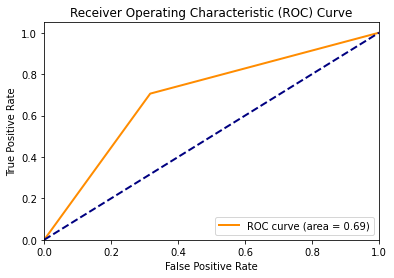

In [77]:
# Plot or analyze the ROC curve here
filename="/workspace/home/img/{}_{}_{}_ROC.jpg".format(model_name,version,parameters)
plot_AUC_curve(y_true,y_pred,filename)

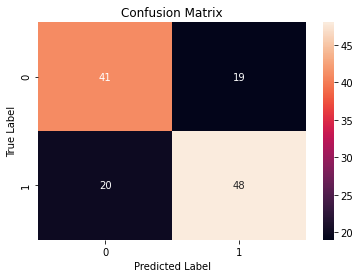

In [78]:
cm = confusion_matrix(y_true, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d')  # Annotate with values, format as integers
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
filename="/workspace/home/img/{}_{}_{}_CM.jpg".format(model_name,version,parameters)
#filename="/workspace/home/VGG_0_m_loss_CM_1.jpg"
plt.savefig(filename, format='jpg')  # Adjust dpi as needed
plt.show()
plt.close()


In [79]:
precision, recall, thresholds = precision_recall_curve(y_true,y_pred_stat[:,1])
#precision = precision_score(y_true, y_pred)
#recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(classification_report(y_true, y_pred,target_names = ["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.67      0.68      0.68        60
    Positive       0.72      0.71      0.71        68

    accuracy                           0.70       128
   macro avg       0.69      0.69      0.69       128
weighted avg       0.70      0.70      0.70       128



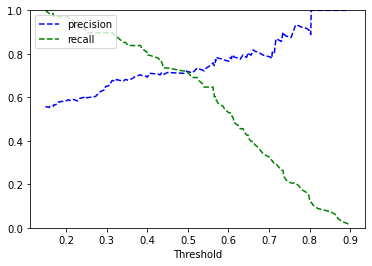

<Figure size 432x288 with 0 Axes>

In [80]:
def plot_precision_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
    plt.show()
    filename="/workspace/home/img/{}_{}_{}_precision_threshold.jpg".format(model_name,version,parameters)
    plt.savefig(filename, format='jpg', dpi=300)  # Adjust dpi as needed
    plt.show()

plot_precision_recall_vs_tresh(precision, recall, thresholds)

In [81]:
# Look at the threshold where recall is 0.8
recall_value = 0.75
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' +str(2 * (precision[idx] * recall[idx]) / (precision[idx] + recall[idx])))

Precision is: 0.7083333333333334
Recall is: 0.75
Threshold is: 0.43764946
F1 Score is: 0.7285714285714285


In [82]:
# Look at the threshold where recall is 0.8
precision_value = 0.75
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' +str(2 * (precision[idx] * recall[idx]) / (precision[idx] + recall[idx])))

Precision is: 0.75
Recall is: 0.6176470588235294
Threshold is: 0.56467426
F1 Score is: 0.6774193548387097


In [83]:
print(classification_report(y_true, y_pred,target_names = ["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.67      0.68      0.68        60
    Positive       0.72      0.71      0.71        68

    accuracy                           0.70       128
   macro avg       0.69      0.69      0.69       128
weighted avg       0.70      0.70      0.70       128



### We want do increase the recal even if the precision decrease slightly , because we wan't to minimize wrong postiive predictions

In [84]:
y_pred_t = y_pred_stat[:,1]>0.4142516
y_pred_t=y_pred_t.astype(int)


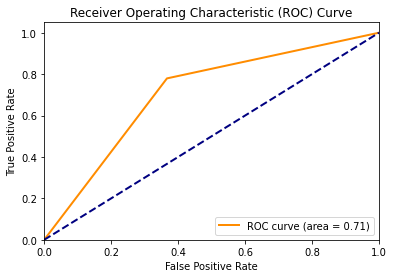

In [85]:
# Plot or analyze the ROC curve here
filename="/workspace/home/img/{}_{}_{}_ROC_threshold.jpg".format(model_name,version,parameters)
plot_AUC_curve(y_true,y_pred_t,filename)

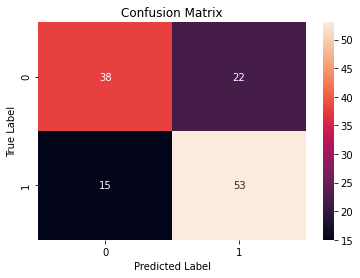

In [86]:
cm = confusion_matrix(y_true, y_pred_t)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d')  # Annotate with values, format as integers
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
filename="/workspace/home/img/{}_{}_{}_CM_threshold.jpg".format(model_name,version,parameters)
#filename="/workspace/home/VGG_0_m_loss_CM_t_1.jpg"
plt.savefig(filename, format='jpg', dpi=300)  # Adjust dpi as needed
plt.show()

In [87]:
print(classification_report(y_true, y_pred_t,target_names = ["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.72      0.63      0.67        60
    Positive       0.71      0.78      0.74        68

    accuracy                           0.71       128
   macro avg       0.71      0.71      0.71       128
weighted avg       0.71      0.71      0.71       128

